In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20


from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sktime.transformations.series.boxcox import BoxCoxTransformer
from statsmodels.tsa.seasonal import STL

# from scipy.special import inv_boxcox
from statsmodels.tsa.seasonal import MSTL

In [2]:
import statsmodels

statsmodels.__version__

'0.14.0.dev579+ga26536041'

In [3]:
df = pd.read_csv(
    "feature-engineering-for-time-series-forecasting/Datasets/example_air_passengers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

In [4]:
df

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [5]:
def plot_ts(df, title_suffix = ""):

    ax = df.plot(figsize = (12,6), marker=".", legend = None);
    ax.set_xlabel("Time");
    ax.set_ylabel("Air passengers (1000s)");
    ax.set_title("Air passenger numbers" + title_suffix);
    plt.show();

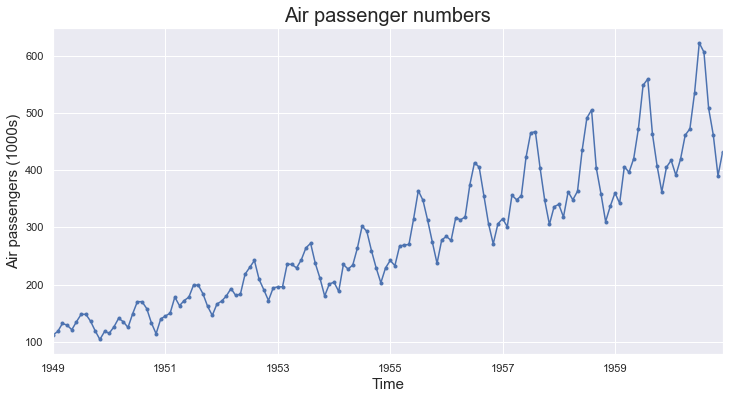

In [6]:
plot_ts(df = df)

### Apply BoxCox to convert multplicate TS to  additive TS tp make the Magnitude of the TS constant over time.

In [7]:
#Log transform by setting Lambda = 0
df["y_log"] = boxcox(df["y"], lmbda = 0)

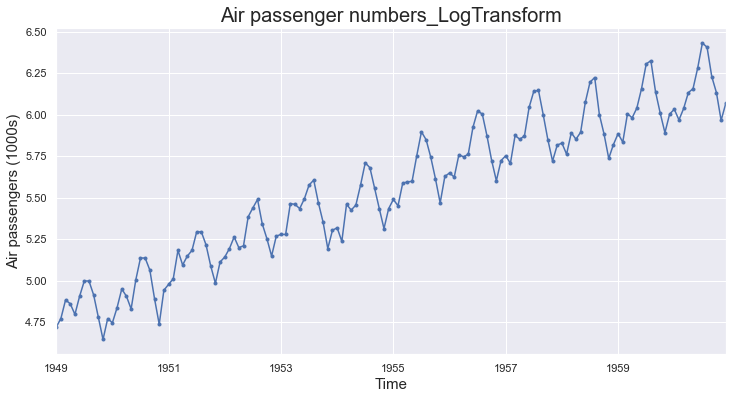

In [8]:
plot_ts(df = df["y_log"], title_suffix = "_LogTransform")

In [9]:
#Finding Lambda automatically by setting Lambda = None. Scipy uses maximum likelihood estimation (MLE) to
#find suitable lambda value

df["y_MLE"], mle_lmbda = boxcox(df["y"], lmbda = None)

MLE selected Lambda: 0.148


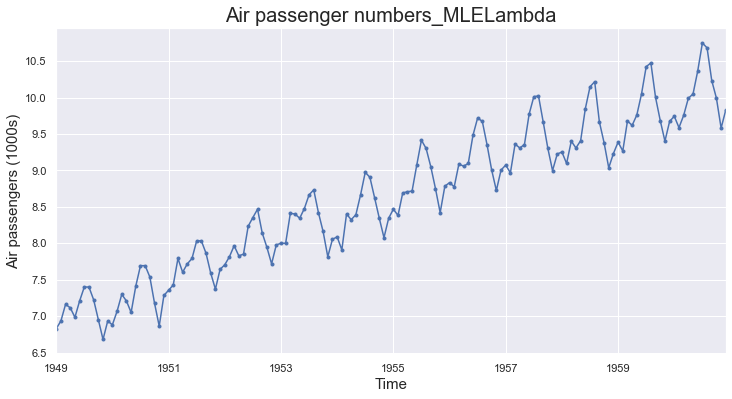

In [10]:
print(f"MLE selected Lambda: {mle_lmbda:.3f}")

plot_ts(df = df["y_MLE"], title_suffix = "_MLELambda")

# Estimating Lambda using guerrero is a better way

In [11]:
transformer = BoxCoxTransformer(
    method="guerrero",
    sp=12 # sp should be set to the seasonal period
)

df["y_guerrero"] = transformer.fit_transform(df["y"])

Guerrero selected Lambda: -0.295


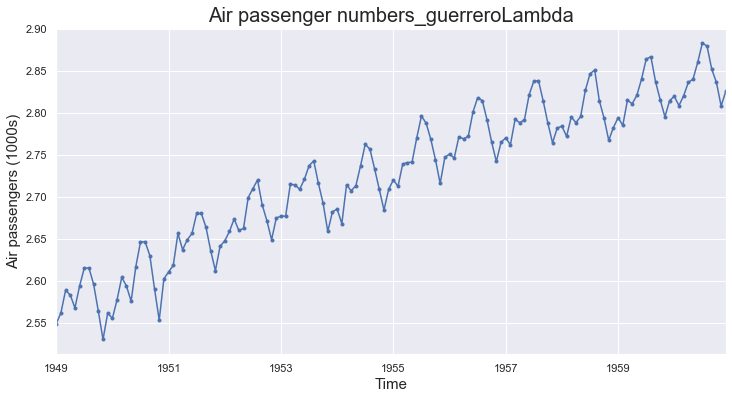

In [12]:
print(f"Guerrero selected Lambda: {transformer.lambda_:.3f}")

plot_ts(df = df["y_guerrero"], title_suffix = "_guerreroLambda")

# Extract Trend, seasonality and residual components from the above TS

In [13]:
df.head()

,y,y_log,y_MLE,y_guerrero
ds,,,,
1949-01-01,112,4.718499,6.827490,2.548446
1949-02-01,118,4.770685,6.932822,2.561336
1949-03-01,132,4.882802,7.161892,2.588369
1949-04-01,129,4.859812,7.114611,2.582898
1949-05-01,121,4.795791,6.983787,2.567468


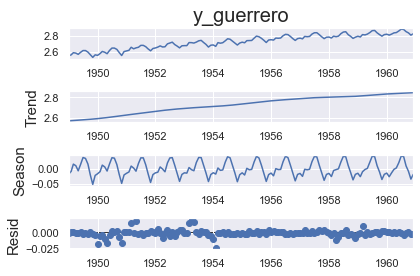

In [14]:
# Perform STL decomposition
res = STL(
    endog=df["y_guerrero"],  # Y values in addtive order
    period=12,  # The periodicity of the seasonal component
    seasonal=7,  # Determines the window size for LOESS used
    # when smoothing the seasonal component
    # (i.e, the cycle-subseries)
    robust=True  # Flag to use robust regression when
    # fitting the LOESS curves so the fit
    # is robust to outliers
).fit()


# plt.rc("figure", figsize=(10, 10))
# plt.rc("font", size=5)
res.plot();

In [15]:
# Extract the trend and seasonality individually
df["trend"] = res.trend
df["seasonal"] = res.seasonal
df.head()

,y,y_log,y_MLE,y_guerrero,trend,seasonal
ds,,,,,,
1949-01-01,112,4.718499,6.827490,2.548446,2.567293,-0.018008
1949-02-01,118,4.770685,6.932822,2.561336,2.568966,-0.008544
1949-03-01,132,4.882802,7.161892,2.588369,2.570650,0.016200
1949-04-01,129,4.859812,7.114611,2.582898,2.572349,0.010808
1949-05-01,121,4.795791,6.983787,2.567468,2.574066,-0.006623


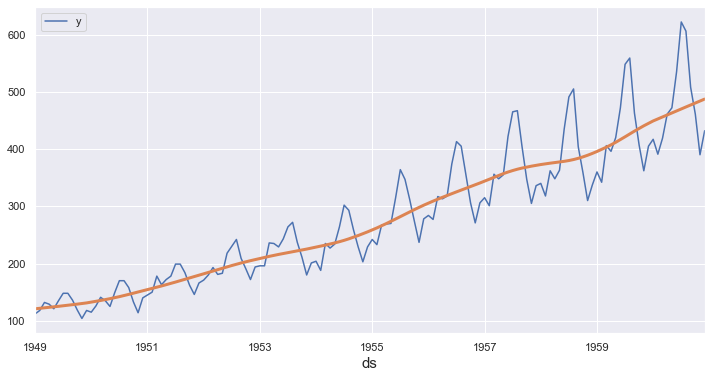

In [16]:
#Need to inverse transform trend inorder to plot with y

ax = df["y"].plot(figsize = (12, 6));
transformer.inverse_transform(df["trend"]).plot(lw = 3,);

plt.legend();

# Alternatvely, Performing STL directly on y without converting TS to additive model.

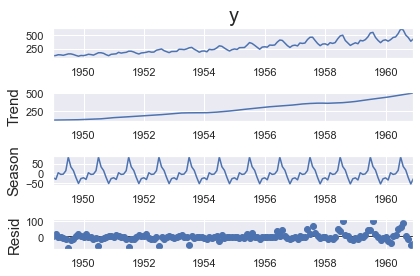

In [17]:
#check notebook about seasonal_deg parameter. This is done mostly to obtain an additive seasonality.


# Perform STL decomposition
res = STL(
    endog=df["y"],  # Y values in addtive order
    period=12,  # The periodicity of the seasonal component
    seasonal=31,  # Determines the window size for LOESS used
    # when smoothing the seasonal component
    # (i.e, the cycle-subseries)
    seasonal_deg=0, 
    robust=True  # Flag to use robust regression when
    # fitting the LOESS curves so the fit
    # is robust to outliers
).fit()


# plt.rc("figure", figsize=(10, 10))
# plt.rc("font", size=5)
res.plot();

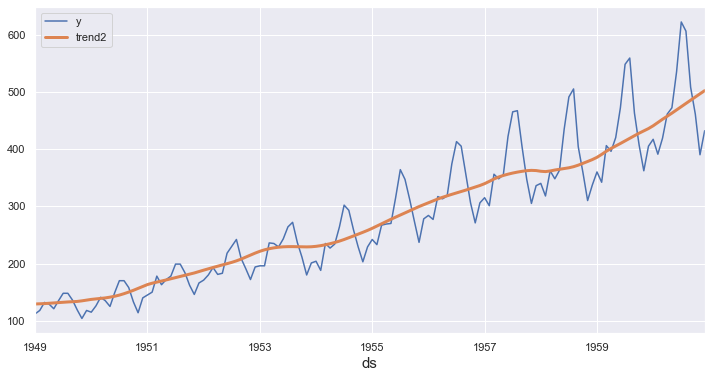

In [18]:
df["trend2"] = res.trend
df["seasonal2"] = res.seasonal

ax = df["y"].plot(figsize = (12, 6));
df["trend2"].plot(lw = 3,);

plt.legend();

# MSTL - Decomposition of time series having multiple seasonalities

In [19]:
df = pd.read_csv(
    "feature-engineering-for-time-series-forecasting/Datasets/victoria_electricity_demand.csv",
    usecols=["date_time", "demand"],
    parse_dates=["date_time"],
    index_col=["date_time"],
)

df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 115368 entries, 2002-01-01 00:00:00 to 2015-02-28 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   demand  115368 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


In [21]:
#taking a subset of data
sd = pd.to_datetime("2012-01-01")

df_smpl = df.loc[sd: sd + pd.Timedelta("149D")] # from 1 day of 2012 until 149 days after the start date.

# Compute date time variables used later in plotting
df_smpl["week"] = df_smpl.index.isocalendar().week
df_smpl["day_of_month"] = df_smpl.index.day
df_smpl["month"] = df_smpl.index.month

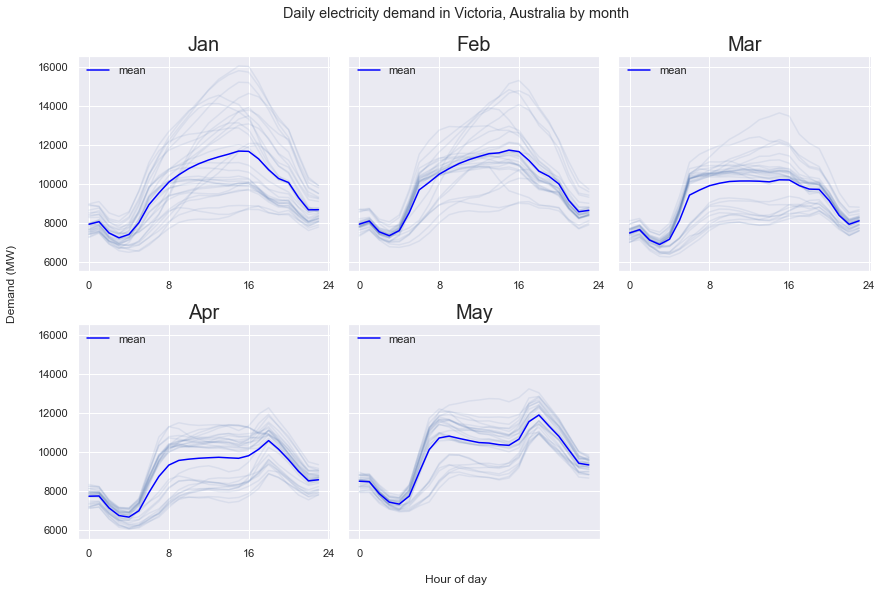

In [22]:
# Plot the electricity demand for each day in each month
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[12, 8], sharey=True)
ax = ax.flatten()

sns_blue = sns.color_palette(as_cmap=True)[0] # Get seaborn blue color
MONTHS = ["Jan", "Feb", "Mar", "Apr", "May"]

for ix, month in enumerate(MONTHS): # Iterate over each month

    # Plot individual time series for each day 
    daily_ts = []
    for _, ts in ( # Loop over the demand for each day in a given month
        df_smpl[["demand", "day_of_month", "month"]]
        .query(f"month == {ix+1}") # Filter timeseries to a single month
        .groupby("day_of_month") 
    ):
        ts = ts.reset_index()
        daily_ts.append(ts["demand"]) # Store the daily demand time series
        ts["demand"].plot( # Plot the time series for a single day
            alpha=0.1, ax=ax[ix], color=sns_blue, label="_no_legend_"
            )
        ax[ix].set_xticks(np.arange(0, len(ts) + 1, 8))
        ax[ix].set_title(month)

    # Plot average electricity demand at each hour of the day
    pd.concat(daily_ts, axis=1).mean(axis=1).plot(
        ax=ax[ix], color="blue", label="mean", legend=True
    ) # Compute average of the daily time series and plot it
    ax[ix].legend(loc="upper left", frameon=False)

#     if month in ("Jan", "Feb"):
#         ax[ix].tick_params(
#             axis="x", which="both", bottom=False, top=False, labelbottom=False
#         )

fig.text(0.5, -0.02, "Hour of day", ha="center")
fig.text(-0.02, 0.5, "Demand (MW)", va="center", rotation="vertical")
fig.suptitle("Daily electricity demand in Victoria, Australia by month")
fig.delaxes(ax[-1])
fig.tight_layout()

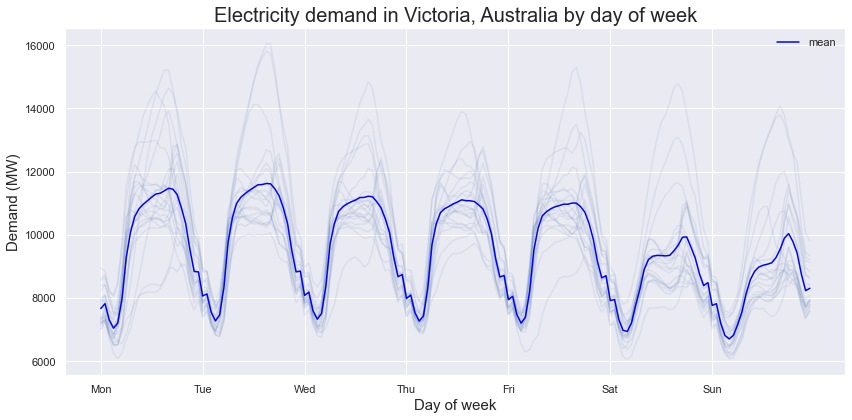

In [23]:
fig, ax = plt.subplots(figsize=[12, 6])

weekly_ts = []
sns_blue = sns.color_palette(as_cmap=True)
DAYS = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# Iterate over each week
for week, ts in df_smpl.groupby("week"):
    ts = ts.reset_index()
    
    weekly_ts.append(ts["demand"]) # Store the weekly time series 
    ts["demand"].plot( # Plot the weekly time series
        alpha=0.1, ax=ax, label="_no_legend_", color=sns_blue)
    
    plt.xticks(ticks=np.arange(0, 167, 24), labels=DAYS)

pd.concat(weekly_ts, axis=1).mean(axis=1).plot( # Compute average over all weeks and plot average
    ax=ax, color="blue", label="mean", legend=True
)

ax.set_ylabel("Demand (MW)")
ax.set_title("Electricity demand in Victoria, Australia by day of week")
ax.set_xlabel("Day of week")
ax.legend(loc="upper right", frameon=False)

plt.tight_layout();

In [24]:
mstl = MSTL(df_smpl["demand"], periods=(24, 24 * 7), stl_kwargs={"seasonal_deg": 0})
res = mstl.fit()

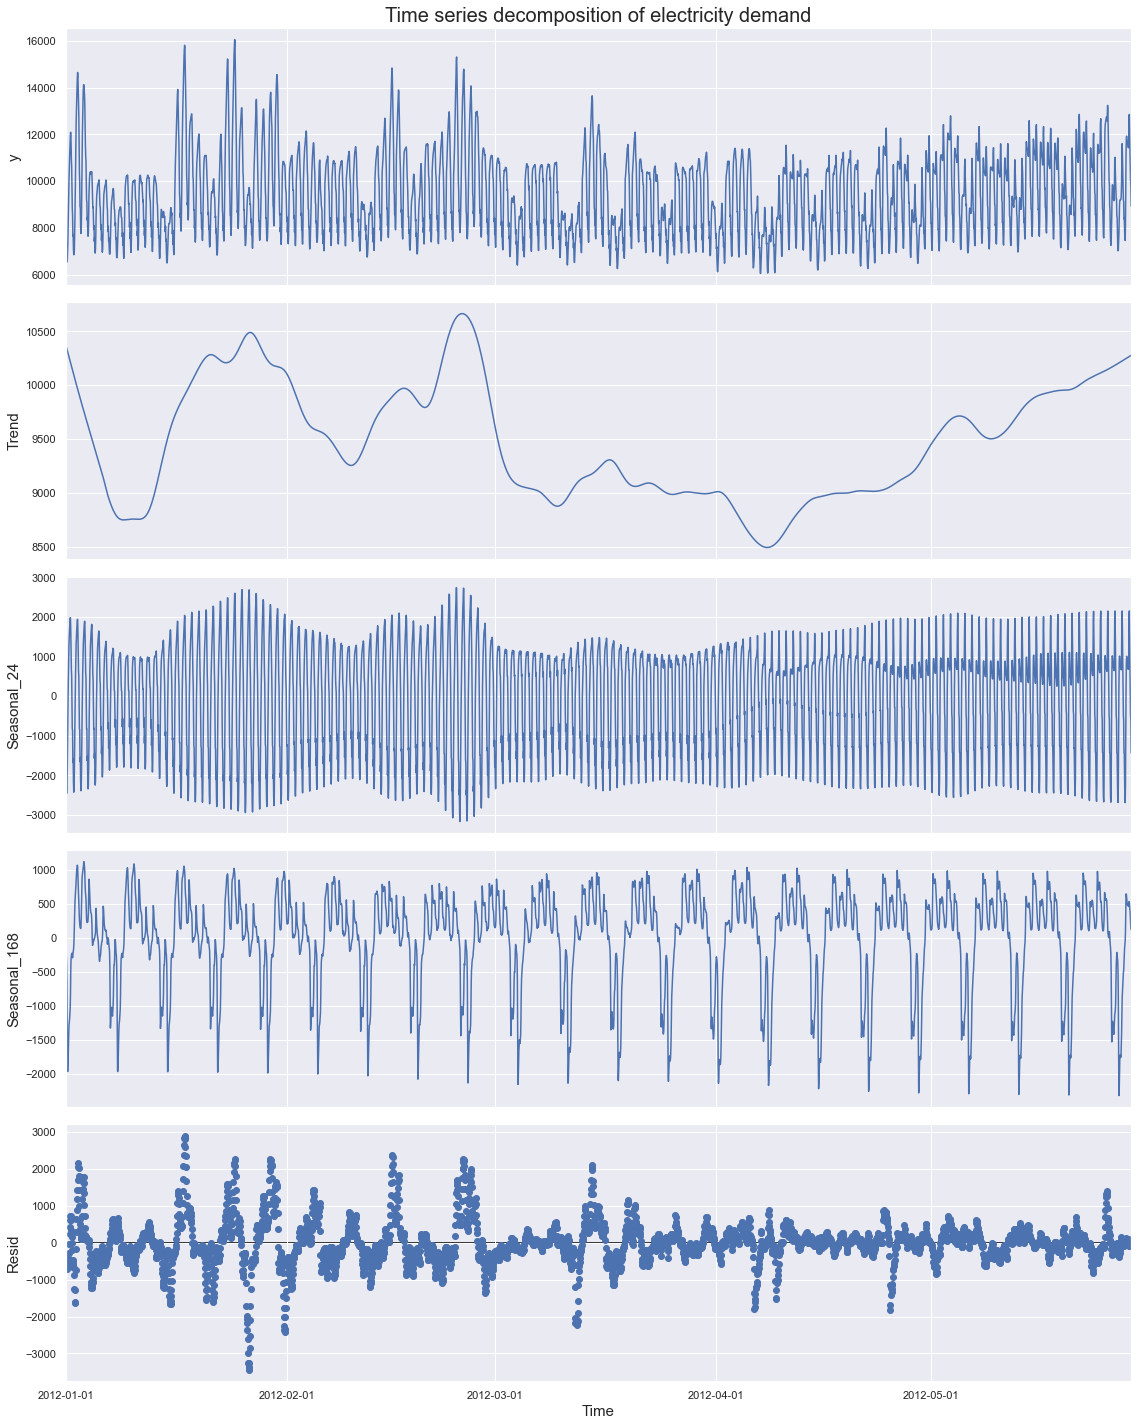

In [26]:
# Start with the plot from the results object `res`
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = res.plot()

# Make plot pretty
axs = fig.get_axes()

ax_last = axs[-1]
ax_last.xaxis.set_ticks(pd.date_range(start="2012-01-01", freq="MS", periods=5))
plt.setp(ax_last.get_xticklabels(), rotation=0, horizontalalignment="center")
for ax in axs[:-1]:
    ax.get_shared_x_axes().join(ax, ax_last)
    ax.xaxis.set_ticks(pd.date_range(start="2012-01-01", freq="MS", periods=5))
    ax.set_xticklabels([])
axs[0].set_ylabel("y")
axs[0].set_title("Time series decomposition of electricity demand")
ax_last.set_xlabel("Time")

plt.tight_layout()

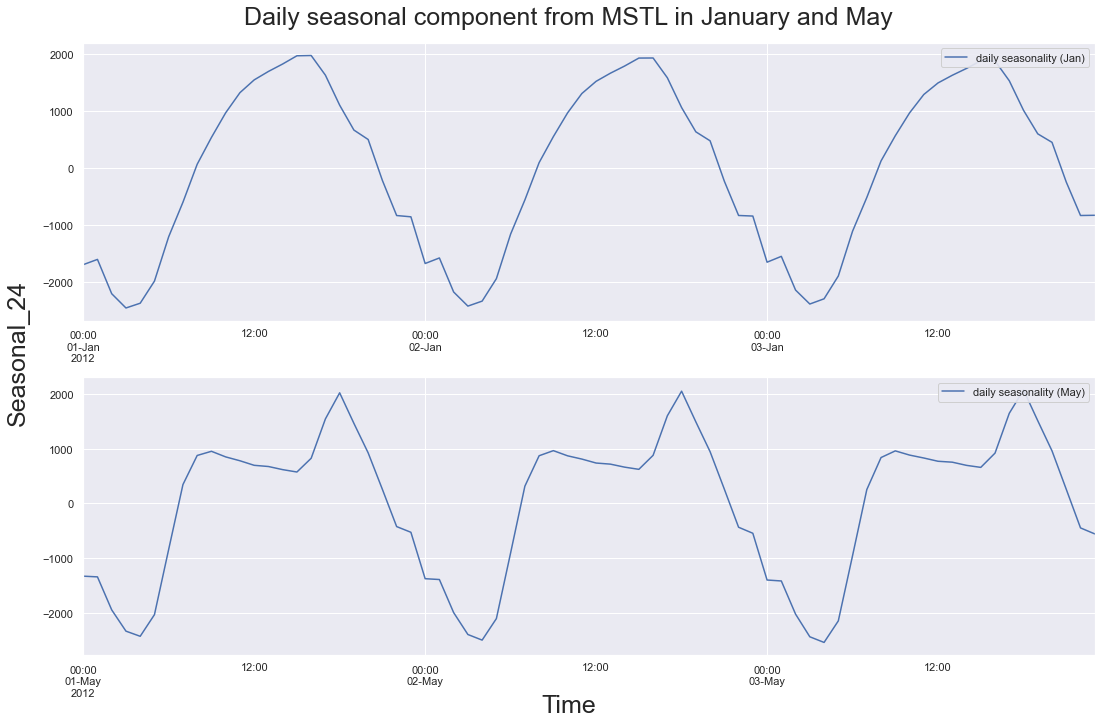

In [27]:
fig, ax = plt.subplots(nrows=2, figsize=[15, 10])
ax = ax.flatten()

# Plot daily seasonality in January
res.seasonal["seasonal_24"].iloc[: 24 * 3].plot(
    ax=ax[0], label="daily seasonality (Jan)", legend=True
)
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].legend(loc="upper right", framealpha=0.9)

# Plot daily seasonality in May
mask = res.seasonal.index.month == 5
res.seasonal[mask]["seasonal_24"].iloc[: 24 * 3].plot(
    ax=ax[1], label="daily seasonality (May)", legend=True
)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].legend(loc="upper right", framealpha=0.9)

# Figure labels
fig.suptitle("Daily seasonal component from MSTL in January and May", fontsize=25)
fig.text(0.5, 0, "Time", ha="center", fontsize=25)
fig.text(-0.02, 0.5, "Seasonal_24", va="center", rotation="vertical", fontsize=25)

plt.tight_layout()

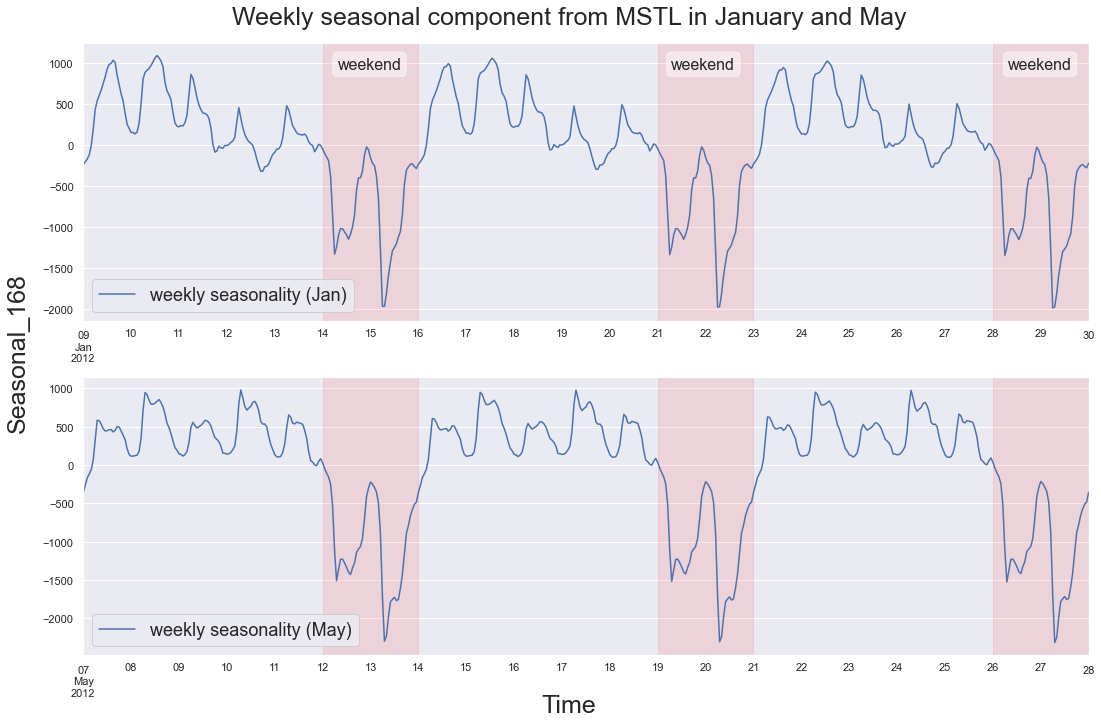

In [28]:
fig, ax = plt.subplots(nrows=2, figsize=[15, 10])
ax = ax.flatten()

# Plot weekly seasonality in January
start = pd.Timestamp("2012-01-09")  # Monday
end = start + pd.Timedelta("3W")
res.seasonal["seasonal_168"].loc[start:end].plot(
    ax=ax[0], label="weekly seasonality (Jan)", legend=True
)
ax[0].set_ylabel("seasonal_168")
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].legend(loc="lower left", framealpha=0.9, fontsize=18)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.253,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.585,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.92,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

weekends = [
    ("2012-01-14", "2012-01-16"),
    ("2012-01-21", "2012-01-23"),
    ("2012-01-28", "2012-01-30"),
]
for start_, end_ in weekends:
    ax[0].axvspan(start_, end_, alpha=0.1, color="red")

# Plot weekly seasonality in May
mask = res.seasonal.index.month == 5
start = pd.Timestamp("2012-05-7")
end = start + pd.Timedelta("3W")
res.seasonal[mask]["seasonal_168"].loc[start:end].plot(
    ax=ax[1], label="weekly seasonality (May)", legend=True
)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].legend(loc="lower left", framealpha=0.9, fontsize=18)

weekends = [
    ("2012-05-12", "2012-05-14"),
    ("2012-05-19", "2012-05-21"),
    ("2012-05-26", "2012-05-28"),
]
for start_, end_ in weekends:
    ax[1].axvspan(start_, end_, alpha=0.1, color="red")

# Figure labels
fig.suptitle("Weekly seasonal component from MSTL in January and May", fontsize=25)
fig.text(0.5, 0, "Time", ha="center", fontsize=25)
fig.text(-0.02, 0.5, "Seasonal_168", va="center", rotation="vertical", fontsize=25)

plt.tight_layout()